In [124]:
import numpy as np
import scipy.signal as sig
import Dataset as ds
import matplotlib.pyplot as plt
import h5py

In [125]:
data_path = r"C:/Data/20230804/"
data_path_new = r"C:/Data/20231218/"
data_path_highrange =  r"C:/Data/20240229/NoPulse/"
data_path_noise = r"C:/Data/20240229/WithVoltage/"


In [126]:
filename = '*.h5'

In [127]:
dset = ds.Dataset(data_path, Selection=filename)
dset_new = ds.Dataset(data_path_new, Selection=filename)
dset_highrange = ds.Dataset(data_path_highrange, Selection=filename)
dset_noise = ds.Dataset(data_path_noise, Selection=filename)


In [128]:
ch = dset.InitializeChannels()
dset.ImportDataFromHDF5(dset.Files[0], ch)
ch_new = dset_new.InitializeChannels()
dset_new.ImportDataFromHDF5(dset_new.Files[0], ch_new)
ch_highrange = dset_highrange.InitializeChannels()
dset_highrange.ImportDataFromHDF5(dset_highrange.Files[0], ch_highrange)
ch_noise = dset_noise.InitializeChannels()
dset_noise.ImportDataFromHDF5(dset_noise.Files[0], ch_noise)

In [129]:
print(np.shape(ch_new[0].Amp[0]))

(9616,)


0
1


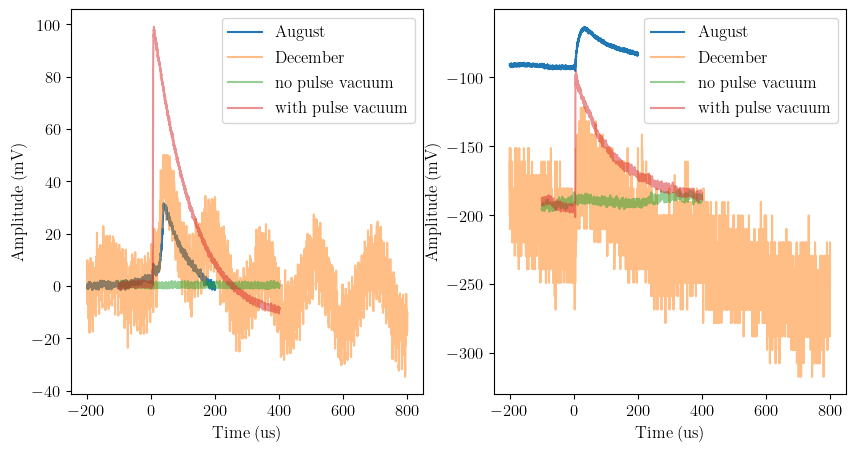

In [130]:
gain_corr = [1e-2, 1]
plt.figure(figsize=(10,5))

for i, (_, gain) in enumerate(zip(ch, gain_corr)):
    print(i)
    plt.subplot(1,2,1+i)
    plt.plot(ch[i].Time, ch[i].Amp[0], label='August')
    plt.plot(ch_new[i].Time, ch_new[i].Amp[0]*gain, label='December', alpha=0.5) # Amp[0] - cathode
    plt.plot(ch_highrange[i].Time, ch_highrange[i].Amp[0], alpha=0.5, label='no pulse vacuum')
    plt.plot(ch_noise[i].Time, ch_noise[i].Amp[0], alpha=0.5, label='with pulse vacuum')
    plt.xlabel("Time (us)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()



In [131]:
def get_psd(channel, tcut=-20, gain_corr=1, avg_factor=4):

    nwfms = len(channel.Amp)

    cut_pts = channel.Time < tcut
    fsamp = 1/(channel.Time[1]-channel.Time[0])

    time_stream = channel.Amp[0][cut_pts]*gain_corr
    
    npts = 2**int(np.log2(len(time_stream))) # largest power of 2 less than the length of the time stream - longest the data segment can be
    freqs = np.fft.rfftfreq(int(npts/avg_factor)) # ffts only work on powers of 2

    avg_psd = np.zeros(len(freqs))

    # print(len(time_stream))
    # print(npts)

    for i in range(nwfms):

        # print(len(time_stream))

        fs, psd = sig.welch(time_stream, nperseg=npts/avg_factor, fs=fsamp)
        avg_psd += psd

    avg_psd = avg_psd/nwfms
    return fs, avg_psd

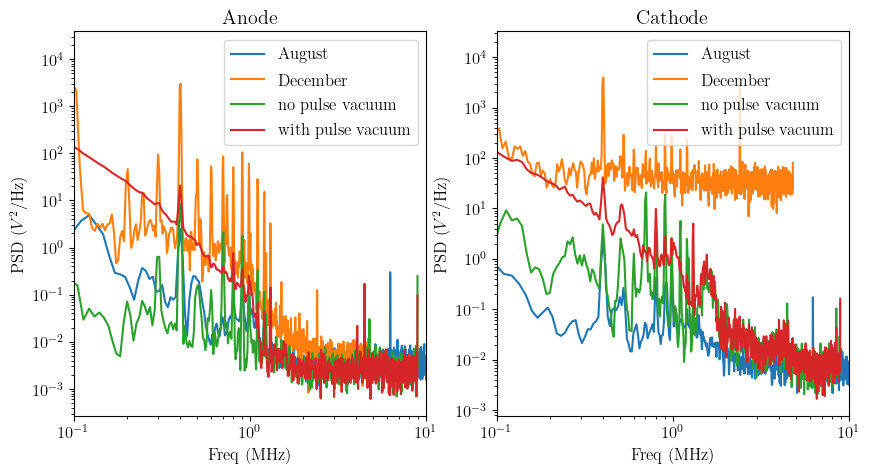

In [132]:
plt.figure(figsize=(10,5))

label = ['Anode', 'Cathode']
for i, (_, gain, lab) in enumerate(zip(ch, gain_corr, label)):
    fs, psd = get_psd(ch[i], tcut=1e20)
    fs_new, psd_new = get_psd(ch_new[i], tcut=1e20)
    fs_highrange, psd_highrange = get_psd(ch_highrange[i], tcut=1e20)
    fs_noise, psd_noise = get_psd(ch_noise[i], tcut=1e20)

    plt.subplot(1,2,1+i)
    plt.loglog(fs, psd, label='August')
    plt.loglog(fs_new, psd_new*gain**2, label='December')
    plt.loglog(fs_highrange, psd_highrange, label='no pulse vacuum')
    plt.loglog(fs_noise, psd_noise, label='with pulse vacuum')
    plt.xlim(0.1, 10)
    plt.ylabel(r'PSD ($V^2$/Hz)')
    plt.xlabel('Freq (MHz)')
    plt.title(lab)
    plt.legend()


In [8]:
file_old = r"C:/Data/20230804/LXe_C1000_A156_0.0V_0.h5"
f = h5py.File(file_old, 'r')  
k = list(f['ch1'].keys())[0]
data_old = np.ndarray.flatten(np.array(f['ch1'][k]))

file_new = r"C:/Data/20231218/Waveform_test_1100V_200V_0.0V_0.h5"
f = h5py.File(file_new, 'r')  
k = list(f['ch1'].keys())[0]
data_new = np.ndarray.flatten(np.array(f['ch1'][k]))

In [9]:
print(data_new)

[-0.67871094 -0.51269531 -0.38574219 ... -1.11816406 -1.39160156
 -1.71386719]


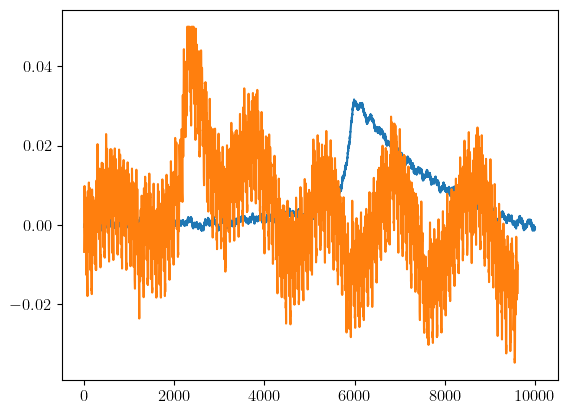

In [11]:

plt.figure()
plt.plot(data_old)
plt.plot(data_new/100)